# Goal
E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, etc. Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning.

# Description of Tasks

To build a model that predicts **whether a user has a high probability of using the site to perform some illegal activity or not.** 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [51]:
data = pd.read_csv('Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,"""user_id""",signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 "user_id"        151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


In [6]:
address2country = pd.read_csv('IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
address2country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


## Note:

Both dataframe seem to be clean, without the presence of null value. Then we proceed to the next step which is feature engineering. 

## Pre-Processing of the Data

1. Convert IP address to country ID (with address2country data).  
2. Calculate the time interval between 'sign-up' and 'purchase'. It takes time for a person to sign-up, type in information, verify email, and complete the transaction. But if the time interval is unusualy short, it is likely the transaction is done by robots (or software). 
3. Calculate the number of users per device ID. The higher the more suspicious.
4. Calculate the number of users per IP address. The higher the more suspicious.
5. Calculate the number of device ID per IP address. The higher the more suspicious.
6. Sign-up day and week.
7. Purchase day and week. 
8. Drop user ID as it is unique and not important. 

In [8]:
# 1. Convert IP address to country ID (with address2country data).  

countries = []

for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = address2country[(address2country['lower_bound_ip_address'] <= ip_address) &
                          (address2country['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
data['country'] = countries

In [52]:
data['country'] = countries

In [53]:
# 2. Calculate the time interval between 'sign-up' and 'purchase'. 
time_interval = data['purchase_time'] - data['signup_time']
time_interval = time_interval.apply(lambda x: x.seconds)
data['time_interval'] = time_interval

In [54]:
# 3. Calculate the number of users per device ID.
data.rename(columns={' "user_id"': 'user_id'}, inplace=True)
user_per_device = data[['user_id', 'device_id']].groupby('device_id').count().reset_index().rename(columns={'user_id': 'user_per_device'})
data = data.merge(user_per_device, how='left', on='device_id')

In [55]:
# 4. Calculate the number of users per IP address.
user_per_IP = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index().rename(columns={'user_id': 'user_per_IP'})
data = data.merge(user_per_IP, how='left', on='ip_address')

In [56]:
# 5. Calculate the number of device ID per IP address. 
device_per_IP = data[['device_id', 'ip_address']].groupby('ip_address').count().reset_index().rename(columns={'device_id': 'device_per_IP'})
data = data.merge(device_per_IP, how='left', on='ip_address')

In [59]:
# 6. Sign-up day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# 7. Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [60]:
data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'time_interval', 'user_per_device', 'user_per_IP',
       'device_per_IP', 'signup_day', 'signup_week', 'purchase_day',
       'purchase_week'],
      dtype='object')

In [61]:
data_processed = data.drop(columns = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'])

In [63]:
data_processed.head()

,purchase_value,source,browser,sex,age,class,country,time_interval,user_per_device,user_per_IP,device_per_IP,signup_day,signup_week,purchase_day,purchase_week
0,34,SEO,Chrome,M,39,0,Japan,13882,1,1,1,1,9,5,16
1,16,Ads,Chrome,F,53,0,United States,17944,1,1,1,6,23,0,24
2,15,SEO,Opera,M,53,1,United States,1,12,12,12,3,1,3,1
3,44,SEO,Safari,M,41,0,NA,60085,1,1,1,1,18,0,19
4,39,Ads,Safari,M,45,0,United States,41461,1,1,1,1,30,2,37


## Comment:

Now we have all data processed and ready for classification models. Before proceeding to buidling models, we look at how our generated attributes, such as user_per_device, user_per_IP and device_per_IP, explain the results.

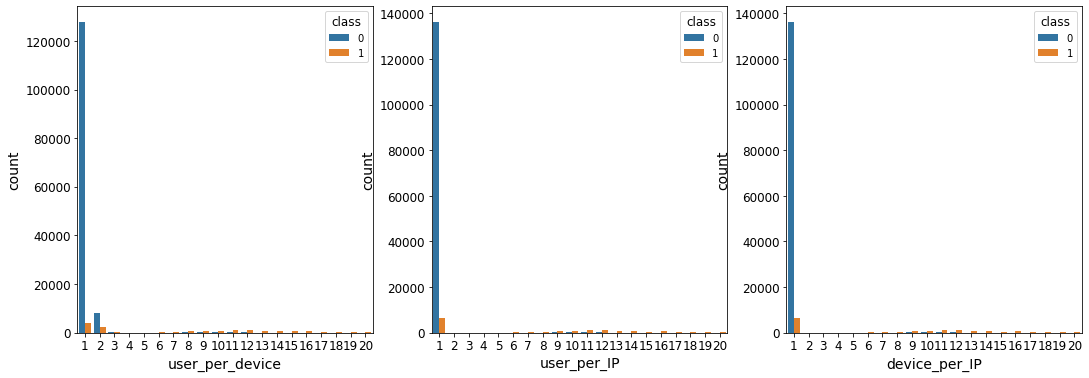

In [68]:
plt.subplots(figsize=(18, 6))
plt.subplot(131)
sns.countplot(x='user_per_device', hue='class', data = data_processed)
plt.subplot(132)
sns.countplot(x='user_per_IP', hue='class', data = data_processed)
plt.subplot(133)
sns.countplot(x='device_per_IP', hue='class', data = data_processed)
plt.show()

In [91]:
data_processed[['user_per_device', 'class']].groupby('class').mean().reset_index().rename(columns={'user_per_device': 'mean user_per_device'})

,class,mean user_per_device
0,0,1.120071
1,1,7.145926


In [92]:
data_processed[['user_per_IP', 'class']].groupby('class').mean().reset_index().rename(columns={'user_per_IP': 'mean user_per_IP'})

,class,mean user_per_IP
0,0,1.053081
1,1,6.922408


## Note: 

The new attributes (user_per_device, user_per_IP and device_per_IP) show contrastly different distributions between two different classes, in agrement with the original hypothesis. 

# Build Classifier based on H2ORandomForestEstimator

## Note:

h2o framework is choosen here due to its good properties such as: 

    1. high training speed. 
    2. effectivenss in dealing with categorical data. 

In [122]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [123]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/mac/anaconda3/h2o_jar/h2o.jar
  Ice root: /var/folders/l7/d1pnsddn4wd3z6qry0tp5rvh0000gn/T/tmp89lnh7sk
  JVM stdout: /var/folders/l7/d1pnsddn4wd3z6qry0tp5rvh0000gn/T/tmp89lnh7sk/h2o_mac_started_from_python.out
  JVM stderr: /var/folders/l7/d1pnsddn4wd3z6qry0tp5rvh0000gn/T/tmp89lnh7sk/h2o_mac_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,"1 year, 7 months and 29 days !!!"
H2O cluster name:,H2O_from_python_mac_f6iilr
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [124]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data_processed)
# make the following as factor (categorical) in H2OFrame
for cat in ['signup_day', 'purchase_day', 'source', 'browser', 'sex', 'country', 'class']:
    h2o_df[cat] = h2o_df[cat].asfactor()
h2o_df.summary()

/Users/mac/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


,purchase_value,source,browser,sex,age,class,country,time_interval,user_per_device,user_per_IP,device_per_IP,signup_day,signup_week,purchase_day,purchase_week
type,int,enum,enum,enum,int,enum,enum,int,int,int,int,enum,int,enum,int
mins,9.0,,,,18.0,,,1.0,1.0,1.0,1.0,,1.0,,1.0
mean,36.935372438985816,,,,33.14070358409648,,,40942.5844274449,1.6843665625496345,1.6027185134205073,1.6027185134205073,,16.501740430938597,,24.65857112605208
maxs,154.0,,,,76.0,,,86399.0,20.0,20.0,20.0,,34.0,,51.0
sigma,18.32276214866213,,,,8.617733490961474,,,26049.66190211836,2.6169536028041773,2.5962395273758414,2.5962395273758414,,9.814287461798868,,11.651556782719494
zeros,0,,,,0,,,0,0,0,0,,0,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,34.0,SEO,Chrome,M,39.0,0,Japan,13882.0,1.0,1.0,1.0,1,9.0,5,16.0
1,16.0,Ads,Chrome,F,53.0,0,United States,17944.0,1.0,1.0,1.0,6,23.0,0,24.0
2,15.0,SEO,Opera,M,53.0,1,United States,1.0,12.0,12.0,12.0,3,1.0,3,1.0


In [125]:
# Split into training and test dataset with a ratio of 0.8 to 0.2

split = h2o_df['class'].stratified_split(test_frac=0.2, seed=42)
train = h2o_df[split == 'train']
test = h2o_df[split == 'test']
# Define features and target
feature = ['purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_interval', 'user_per_device', 'user_per_IP', 'device_per_IP',
           'signup_day', 'signup_week', 'purchase_day', 'purchase_week']
target = 'class'

In [126]:
# Build random forest model 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1, stopping_rounds=5, 
                                 stopping_metric='auc', score_each_iteration=True, seed=42)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)
model.score_history()

drf Model Build progress: |███████████████████████████████████████████████| 100%


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
0,,2019-11-04 11:15:09,0.190 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-11-04 11:15:11,1.863 sec,1.0,0.355648,0.702749,0.946029,1.947735,0.121820,0.242739,1.292381,0.792555,8.033577,0.058699
2,,2019-11-04 11:15:12,2.830 sec,2.0,0.349602,0.644424,0.952586,1.954837,0.110292,0.208114,0.528970,0.815274,10.340990,0.044901
3,,2019-11-04 11:15:13,4.430 sec,3.0,0.343068,0.591808,0.960074,1.959971,0.098314,0.203808,0.394265,0.825041,10.595612,0.043908
4,,2019-11-04 11:15:14,5.369 sec,4.0,0.340160,0.550673,0.963711,1.965636,0.093616,0.202596,0.333239,0.827450,10.643791,0.043544
5,,2019-11-04 11:15:15,6.714 sec,5.0,0.334484,0.496468,0.969970,1.972056,0.084165,0.202083,0.303498,0.830383,10.672051,0.043478
6,,2019-11-04 11:15:17,7.877 sec,6.0,0.336328,0.458143,0.973115,1.978941,0.080858,0.201615,0.270005,0.834888,10.679152,0.043379
7,,2019-11-04 11:15:17,8.626 sec,7.0,0.332288,0.420423,0.977680,1.983770,0.073737,0.201432,0.253554,0.836572,10.679152,0.043842
8,,2019-11-04 11:15:18,9.560 sec,8.0,0.332877,0.397691,0.979944,1.988039,0.072396,0.201232,0.237692,0.837386,10.679152,0.043280
9,,2019-11-04 11:15:19,10.434 sec,9.0,0.333418,0.383683,0.982030,1.990621,0.068244,0.201184,0.227851,0.837841,10.679152,0.043280


## Note: 

From the traning histroy, the training_classification_error is 0.042306 which is slightly lower than validation_classification_error of 0.043180, indicating no obvious overfitting of this random forrest.

In [161]:
from sklearn.metrics import auc, roc_curve, classification_report

def make_prediction(data, model, thres):
    data_label = data.as_data_frame()['class'].values
    data_pred = model.predict(data).as_data_frame()['p1'].values
    print(classification_report(y_true=data_label, y_pred=(data_pred > thres).astype(int)))

In [162]:
# make prediction on test data
make_prediction(test, model, 0.5)

drf prediction progress: |████████████████████████████████████████████████| 100%
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27392
           1       1.00      0.54      0.70      2830

    accuracy                           0.96     30222
   macro avg       0.98      0.77      0.84     30222
weighted avg       0.96      0.96      0.95     30222



drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


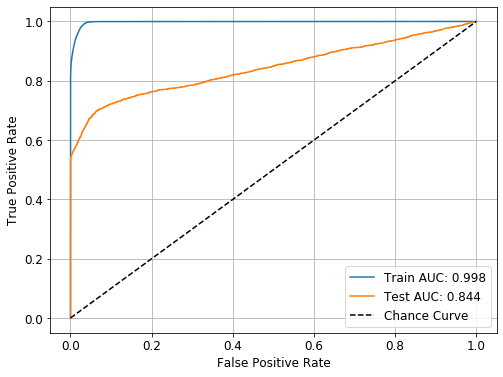

In [157]:
def plotROC(train, test, model):
    train_label = train.as_data_frame()['class'].values
    test_label = test.as_data_frame()['class'].values
    train_pred = model.predict(train).as_data_frame()['p1'].values
    test_pred = model.predict(test).as_data_frame()['p1'].values

    train_fpr, train_tpr, _ = roc_curve(train_label, train_pred)
    test_fpr, test_tpr, _ = roc_curve(test_label, test_pred)
    train_auc = np.round(auc(train_fpr, train_tpr), 3)
    test_auc = np.round(auc(test_fpr, test_tpr), 3)

    train_fpr = np.insert(train_fpr, 0, 0)
    train_tpr = np.insert(train_tpr, 0, 0)
    test_fpr = np.insert(test_fpr, 0, 0)
    test_tpr = np.insert(test_tpr, 0, 0)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
    ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
    ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.grid(True)
    ax.legend(fontsize=12)
    plt.show()

plotROC(train, test, model)

## Note:

Based on the ROC on test set, clearly there is a trade-off between TP rate and FP rate. Since the purpose is to find the fraudulent transaction, one might prefer a higher TP rate to make sure the model has high probability of identifying all true fraud, even through the FP rate will be compromised. 

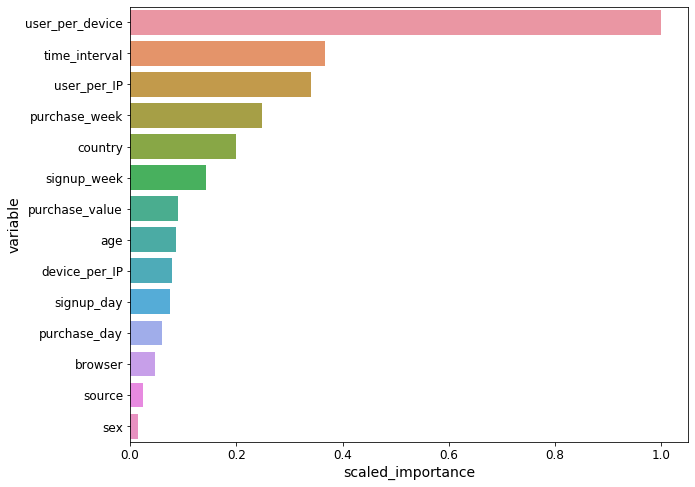

In [159]:
# Visuliazation of Feature importance
importance = model.varimp(use_pandas=True)
plt.subplots(figsize = (10, 8))
sns.barplot(x = 'scaled_importance', y = 'variable', data = importance)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


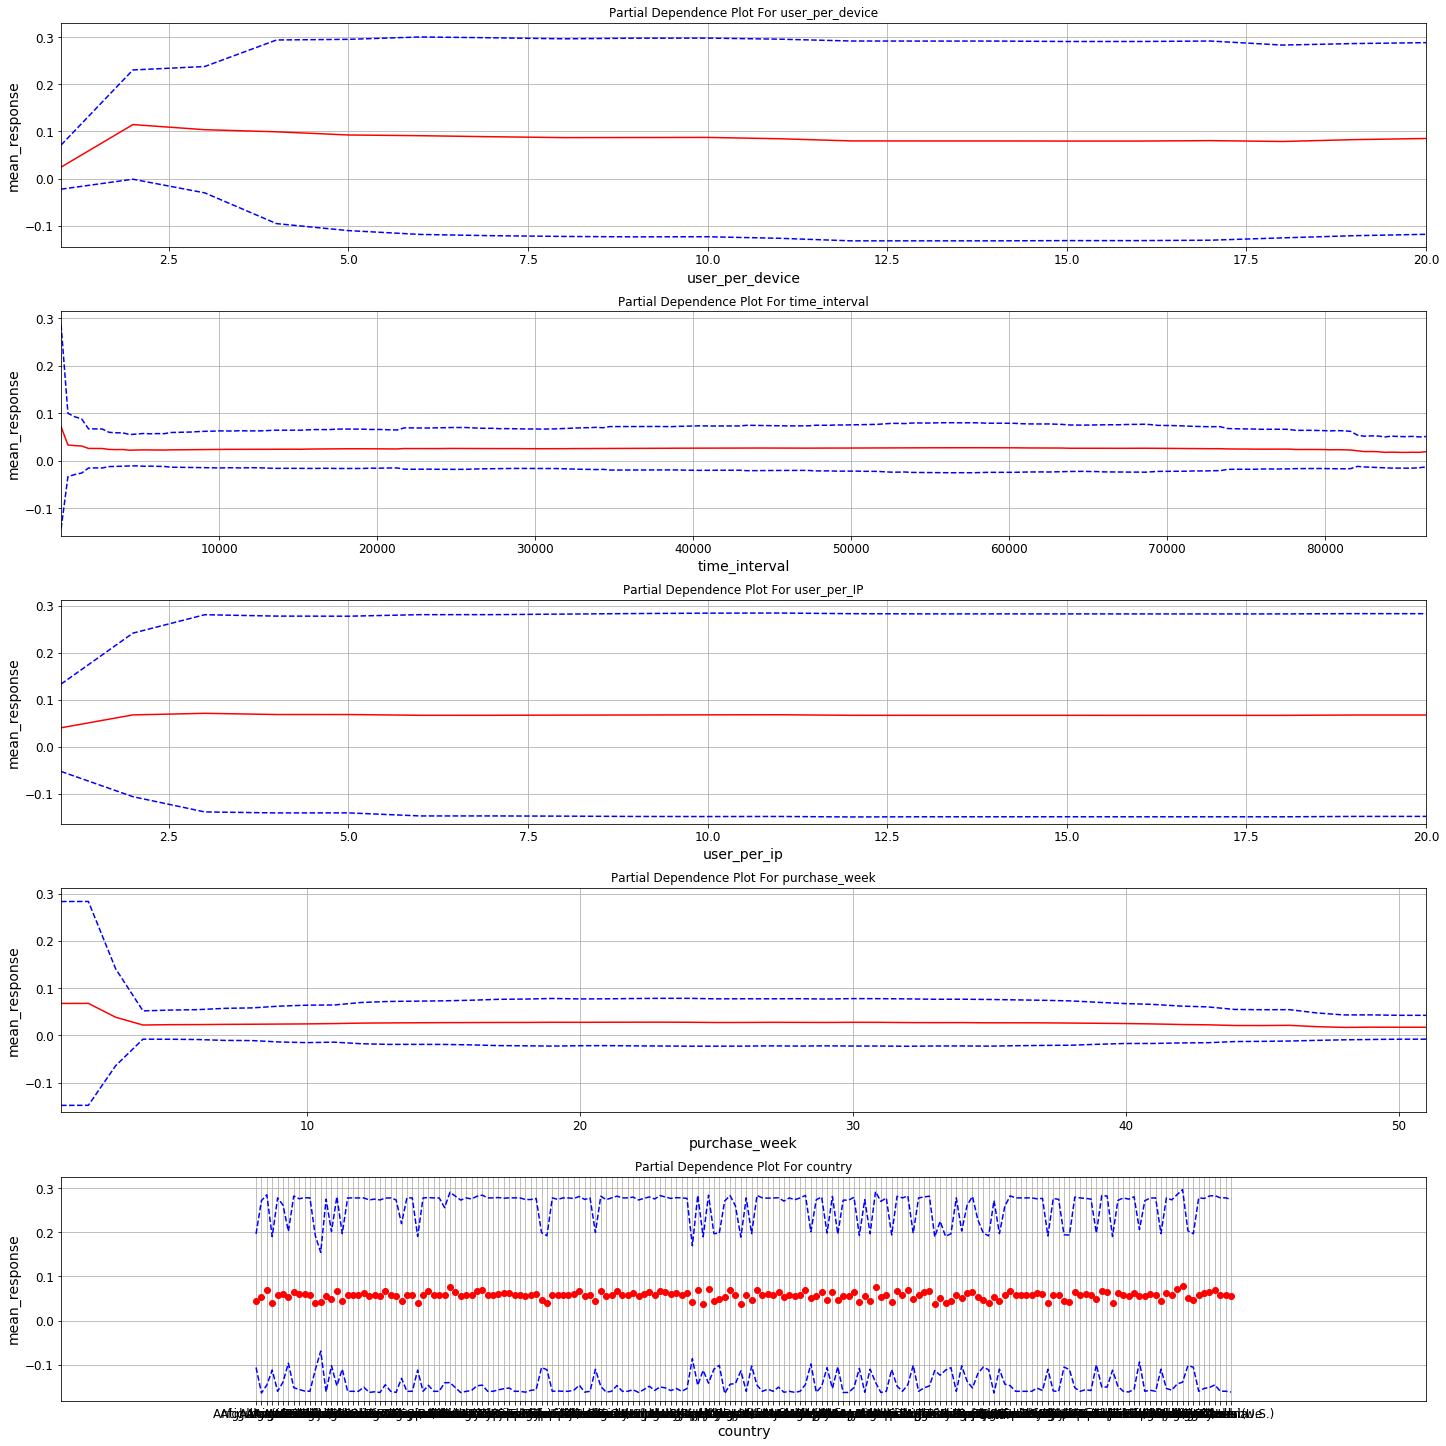

In [158]:
# visulization of partial dependencies of top five most important variables
cols = ['user_per_device', 'time_interval', 'user_per_IP', 'purchase_week', 'country']
_ = model.partial_plot(data=train, cols=cols, nbins=200, figsize=(20, 20))

## Note:

The results above shows that with the generated attributes, the random forrest model is able to explain and predict the class quite well. Clearly, the larger user_per_device and user_per_IP, and the smaller time_interval indicate higher probability of being a fraud. In addition, it seems that fraud tends to happen in the first three weeks of the year. 

### optimize the hyperparameters with H2OGridSearch

In [133]:
from h2o.grid.grid_search import H2OGridSearch

# GBM hyperparameters
gbm_params = {'max_depth': list(range(2, 15, 2)),
              'sample_rate': [i * 0.1 for i in range(5, 11)],
              'ntrees': list(range(100, 1000, 100))}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 16, 'seed': 1}

# Train and validate a random grid of GBMs
gbm_grid = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='gbm_grid',
                          hyper_params=gbm_params,
                          search_criteria=search_criteria)
gbm_grid.train(x=feature, y=target,
                training_frame=train,
                validation_frame=test)

# Get the grid results, sorted by validation AUC
gbm_gridperf = gbm_grid.get_grid(sort_by='auc', decreasing=True)
gbm_gridperf

# Grab the top GBM model, chosen by validation AUC
best_gbm = gbm_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf = best_gbm.model_performance(test)

best_gbm_perf.auc()

drf Grid Build progress: |████████████████████████████████████████████████| 100%


0.8481249522699877

In [166]:
best_gbm_perf


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.038629798554993766
RMSE: 0.19654464773937186
LogLoss: 0.158600211012022
Mean Per-Class Error: 0.17334837387718371
AUC: 0.8481249522699877
Gini: 0.6962499045399755
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22046602373321852: 


,0,1,Error,Rate
0,27125.0,267.0,0.0097,(267.0/27392.0)
1,1157.0,1673.0,0.4088,(1157.0/2830.0)
Total,28282.0,1940.0,0.0471,(1424.0/30222.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2204660,0.7014675,102.0
max f2,0.1179548,0.6727575,217.0
max f0point5,0.9214774,0.8531523,22.0
max accuracy,0.9214774,0.9566872,22.0
max precision,0.9994663,1.0,0.0
max recall,0.0212082,1.0,399.0
max specificity,0.9994663,1.0,0.0
max absolute_mcc,0.9214774,0.7162007,22.0
max min_per_class_accuracy,0.0349023,0.7667845,317.0
max mean_per_class_accuracy,0.1179548,0.8266516,217.0


Gains/Lift Table: Avg response rate:  9.36 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101251,0.9988413,10.6791519,10.6791519,1.0,1.0,0.1081272,0.1081272,967.9151943,967.9151943
,2,0.0200847,0.9984329,10.6791519,10.6791519,1.0,1.0,0.1063604,0.2144876,967.9151943,967.9151943
,3,0.0300774,0.9980523,10.6791519,10.6791519,1.0,1.0,0.1067138,0.3212014,967.9151943,967.9151943
,4,0.0400371,0.9975080,10.6791519,10.6791519,1.0,1.0,0.1063604,0.4275618,967.9151943,967.9151943
,5,0.0500629,0.9931181,10.6791519,10.6791519,1.0,1.0,0.1070671,0.5346290,967.9151943,967.9151943
,6,0.1000265,0.1708533,2.6945410,6.6908084,0.2523179,0.6265299,0.1346290,0.6692580,169.4540987,569.0808396
,7,0.1500232,0.0414496,1.1096141,4.8308206,0.1039047,0.4523599,0.0554770,0.7247350,10.9614067,383.0820608
,8,0.2000199,0.0365101,0.2897718,3.6957462,0.0271343,0.3460711,0.0144876,0.7392226,-71.0228174,269.5746214
,9,0.3000132,0.0346303,0.3251099,2.5723247,0.0304434,0.2408735,0.0325088,0.7717314,-67.4890146,157.2324677
,10,0.4000066,0.0338414,0.3639817,2.0202846,0.0340834,0.1891802,0.0363958,0.8081272,-63.6018316,102.0284597


# Conclusion

## The analysis above shows that: 

    1. user per device, time interval between sign-up and purchase, user per IP, and purchase_week are top four indicators in a classification of a fraud. 
    2. the larger user per device and user per IP strongly indicates that a transaction might be a fraud. 
    3. the fraud transaction usually happens at the begining of the year
    4. the time interval between sigh-up and purchase (end of transtion) is usually short in fraud. 

## Suggestion: 

Given the obvious trade-off between TP and FP rate. One might want to apply the rules below in which two thresholds are introduced. 

1. If predicted fraud probability < threshold_1, the user has the normal experience (the high majority should fall here)

2. If threshold_1 <= predicted fraud probability < threshold_2, the user is at risk (but not too much), you can create an additional verification step, like verify your phone number via a code sent by SMS, use cell phone/email for two-factor authentication, verify by logging in via Facebook.

3. If predicted fraud probability >= threshold_2 (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud.